In [ ]:
import Pkg; Pkg.activate(@__DIR__); Pkg.add("PyPlot"); Pkg.add("ForwardDiff"); Pkg.instantiate()

  Activating project at `/workspaces/lecture-notebooks/Lecture 3`
   Resolving package versions...
  No Changes to `/workspaces/lecture-notebooks/Lecture 3/Project.toml`
  No Changes to `/workspaces/lecture-notebooks/Lecture 3/Manifest.toml`
   Resolving package versions...
  No Changes to `/workspaces/lecture-notebooks/Lecture 3/Project.toml`
  No Changes to `/workspaces/lecture-notebooks/Lecture 3/Manifest.toml`


In [5]:
using LinearAlgebra
using ForwardDiff
using PyPlot

In [6]:
function f(x)
    return x.^4 + x.^3 - x.^2 - x
end

f (generic function with 1 method)

In [7]:
function ∇f(x)
    return 4.0*x.^3 + 3.0*x.^2 - 2.0*x - 1.0
end

∇f (generic function with 1 method)

In [8]:
function ∇2f(x)
    return 12.0*x.^2 + 6.0*x - 2.0
end

∇2f (generic function with 1 method)

In [9]:
x = LinRange(-1.75,1.25,1000)

1000-element LinRange{Float64, Int64}:
 -1.75, -1.747, -1.74399, -1.74099, …, 1.24099, 1.24399, 1.247, 1.25

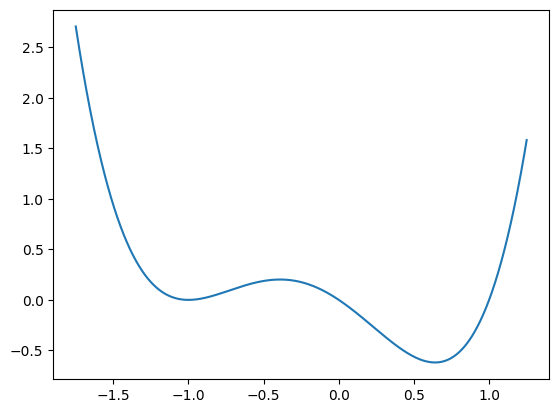

In [10]:
p = plot(x,f(x))
display(gcf())

In [11]:
function newton_step(x0)
    xn = x0 - ∇2f(x0)\∇f(x0)
end

newton_step (generic function with 1 method)

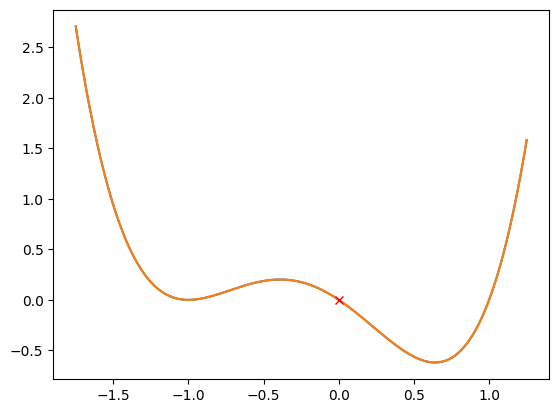

In [12]:
xguess = 0.0
plot(x, f(x))
plot(xguess, f(xguess), "rx")
display(gcf())

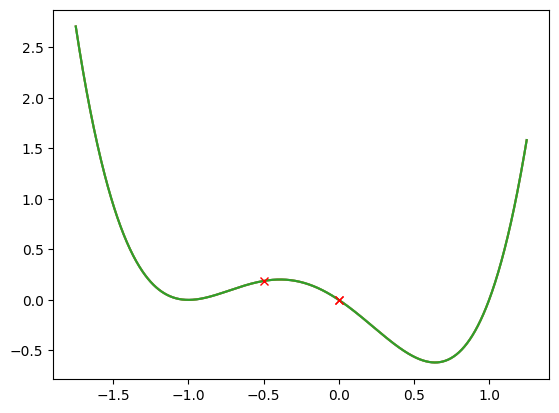

In [13]:
xnew = newton_step(xguess[end])
xguess = [xguess xnew]
plot(x, f(x))
plot(xguess, f(xguess), "rx")
display(gcf())

In [14]:
∇2f(0.0)

-2.0

In [75]:
function regularized_newton_step(x0)
    β = 5.0
    H = ∇2f(x0)
    while !isposdef(H)
        H = H + β*I
    end
    xn = x0 - H\∇f(x0)
end

regularized_newton_step (generic function with 1 method)

In [76]:
clf()

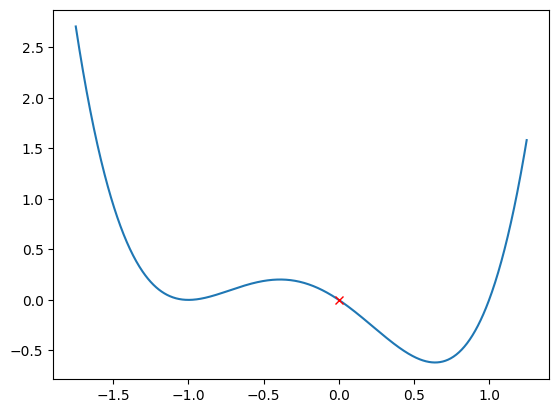

In [77]:
xguess = 0.0
plot(x, f(x))
plot(xguess, f(xguess), "rx")
display(gcf())

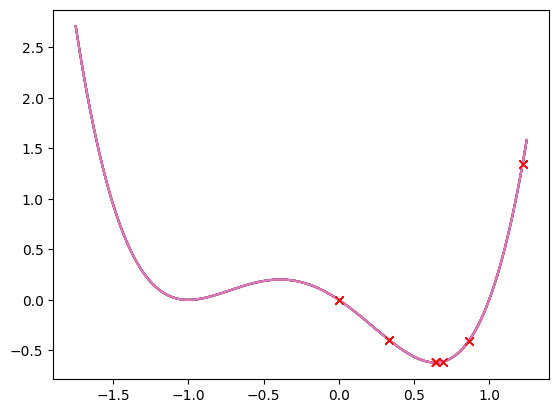

In [83]:
xnew = regularized_newton_step(xguess[end])
xguess = [xguess xnew]
plot(x, f(x))
plot(xguess, f(xguess), "rx")
display(gcf())

第三步迭代发散的原因在于，$\beta$较大，在$\beta$起作用的时候（上凸区域）优化表现地像梯度下降而单调地以小步长下降直到$\beta$不再起作用；而到下凸区域**切换**时，由于刚刚切换，Hessian矩阵某些特征值接近0，从而导致突然地跳跃。

如何让优化过程更加平稳呢？——Levenberg-Marquardt 算法 (LMA) 是一种思路（根据是否完成了下降调整阻尼步长而非在下凸区域完全取消阻尼）

In [61]:
"""
 * @brief 执行单步Levenberg-Marquardt优化。
 *
 * @param f 目标函数。
 * @param ∇f 目标函数的梯度函数。
 * @param ∇²f 目标函数的Hessian函数。
 * @param x_k_ 当前迭代点。
 * @param λ_k_ 当前的阻尼因子。
 * @param v_ 增/减阻尼因子的系数，通常 > 1 (例如 v=2)。
 *
 * @return Tuple{Vector{Float64}, Float64} 返回新的迭代点和新的阻尼因子。
 *
 * @note 这个函数仅执行单步逻辑。在实际使用中，它应该被包裹在一个主循环里。
"""
function levenberg_marquardt_step(f, ∇f, ∇²f, x_k_::Float64, λ_k_::Float64, v::Float64=2.0)
    
    # 获取当前点的函数值、梯度和Hessian
    fk = f(x_k_)
    gk = ∇f(x_k_)
    Hk = ∇²f(x_k_)

    while true
        # 1. 构造修正后的Hessian矩阵
        # 即使Hk是正定的，也加上阻尼项
        H_lm = Hk + λ_k_ * I

        # 检查修正后的Hessian是否正定，如果不是，增加λ再试
        # 这是一种保护措施，对于数值不稳定的情况
        if !isposdef(H_lm)
            λ_k_ *= v
            println("Warning: Modified Hessian is not positive definite. Increasing λ to ", λ_k_)
            continue
        end

        # 2. 计算试验步长 (trial step)
        p_k = -H_lm \ gk
        x_trial = x_k_ .+ p_k

        # 3. 评估试验步的效果
        f_trial = f(x_trial)

        if f_trial < fk
            # 成功的一步：接受移动，并减小阻尼，以便下一步更像牛顿法
            println("Step accepted. New f_val = ", f_trial, ". Decreasing λ.")
            x_k_plus_1 = x_trial
            λ_k_plus_1 = λ_k_ / v
            return x_k_plus_1, λ_k_plus_1
        else
            if norm.(f_trial-fk) < 1e-8
                println("Arrived min f_min = ", fk)
                return x_k_, λ_k_
            end
            # 失败的一步：拒绝移动，并增大阻尼，以便下一步更像梯度下降
            println("Step rejected. f_val did not decrease. Increasing λ.")
            λ_k_ *= v
            # 循环将使用增大的 λ 重新计算步长 p_k
        end
    end
end

levenberg_marquardt_step

In [94]:
clf()

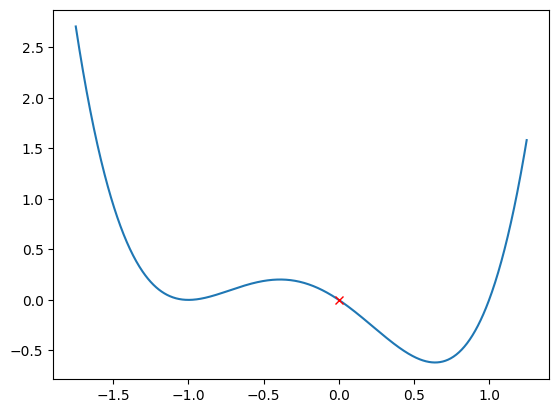

In [95]:
xguess = 0.0
β = 5.0
plot(x, f(x))
plot(xguess, f(xguess), "rx")
display(gcf())

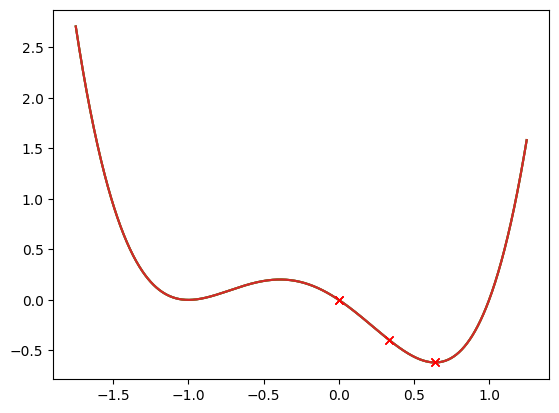

In [98]:
xnew, β = levenberg_marquardt_step(f, ∇f, ∇2f, xguess[end], β)
xguess = [xguess xnew]
println("New guess: ", xguess)
plot(x, f(x))
plot(xguess, f(xguess), "rx")
display(gcf())